## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
import random
import matplotlib as mpl
from keras import backend as K

2022-03-15 15:46:58.624921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 15:46:58.624938: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Collect Training Data from MNIST


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## Set Network Parameters

In [3]:
# Dimension Paramters
intermediate_dim = 256
latent_dim = 2
#Traning Network Paramters
batch_size = 128


## Function to sample from the latent Space

In [4]:
#create the z collection "sampling"
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        #The random portion
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


##  Encoder Model 

In [5]:
#Define the encoder input as a single training data image vector
encoder_inputs = Input(shape=(784,), name='encoder_input')

#Define the encoder layers
x = Dense(intermediate_dim, activation='relu')(encoder_inputs)
x = Dense(intermediate_dim, activation='relu')(x)

#output the mean and log(variance) into the latent space
z_mean = Dense(latent_dim,name='z_mean')(x) 
z_log_var = Dense(latent_dim, name='z_log_var')(x) 

#call our sampling function to collect a z
z = Sampling()([z_mean, z_log_var])


#Create Model for the encoder
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['dense_1[0][0]']                
                                                                                            

2022-03-15 15:47:00.470599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-15 15:47:00.470628: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-15 15:47:00.470640: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (christina-IdeaPad-Flex-5-15IIL05): /proc/driver/nvidia/version does not exist
2022-03-15 15:47:00.470812: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Decoder Model

##  Create the Full Variational Autoencoder Model (VAE)

In [6]:
#The Decoder input is the sample z from the latent space
latent_inputs = keras.Input(shape=(latent_dim,),name='z_sampling')

#Define the encoder layers
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
decoder_output= layers.Dense(784,activation="sigmoid", name='x_mean')(x)

#Create Model for the encoder
decoder = keras.Model(latent_inputs, decoder_output, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 256)               768       
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 x_mean (Dense)              (None, 784)               201488    
                                                                 
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


## Define the Loss Function

In [7]:
#This part of the code is from the tutorial https://blog.keras.io/building-autoencoders-in-keras.html

class VAE(keras.Model):
    """Defines the entier VAE Model"""
    def __init__(self, encoder, decoder, **kwargs):
        """Combines the encoder and decoder together into one model"""
        
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        #create trackers to oberve the loss parameters during training
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [self.total_loss_tracker,self.reconstruction_loss_tracker,self.kl_loss_tracker, ]
  
    def train_step(self, data):
        """ Defines the training process and the loss function"""
        
        with tf.GradientTape() as tape:
            #encode the loss function as a summation of the reconstruction error and KL Divergence
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss =K.sum(K.binary_crossentropy(data, reconstruction),axis=1)
            kl_loss =(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = -0.5 *K.sum(kl_loss, axis=1)
            total_loss = reconstruction_loss +kl_loss
            
        #Calculate the gradient of the loss function and use optimizer to train the weights of the network
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        
        #Update the tracker states
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



## Build the Model

In [8]:
opt= tf.keras.optimizers.Adam(learning_rate=0.001,name='Adam')
vae = VAE(encoder, decoder)
vae.compile(optimizer=opt)

## Visualization: Plot all z samples calulated from input training images in the latent space

In [24]:

def plot_latent_space(set_epochs):
    """Inputs the number of epochs the model was trained on outputs a plot of z samples in latent space"""
    
    #When visualizing data, this is to make sure this function is being called with the model trained to the expected number of epochs
    if epochs == set_epochs:
        
        z_mean,z_log_var, _ = encoder.predict(x_test, batch_size=batch_size)
   
        #Plot the z samples 
        ax= plt.figure(figsize=(6, 6))
        cmap = mpl.cm.get_cmap("viridis")
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test,cmap=cmap)
        
        #create  discrete colorbar to show the labels
        bounds = [0, 1, 2, 3, 4, 5, 6,7,8,9,10]        
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal',label="Image Label")
        cbar.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
        cbar.set_ticklabels(["0", "1", "2", "3", "4", "5", "6", "7","8","9"])
        
        plt.show()
        

## Show 15 images of original and reconstructed images

In [25]:
def plot_images(set_epochs):
    """Inputs the number of epochs the model was trained on and outputs 15 random inpute images and 15 reconstructed images """
    
    #When visualizing data, this is to make sure this function is being called with the model trained to the expected number of epochs
    if epochs == set_epochs:
        _, _, z= encoder.predict(x_test)
        x_decoded = decoder.predict(z)

        n = 15
        all= plt.figure(figsize=(25, 4))
        plt.suptitle("15 original and reconstructed images\n", y=1.05, fontsize=30)

        for i in range(n):
          rand= random.randint(500,2000)
        
        # display original image
          ax = plt.subplot(2, n, i + 1)
          image = tf.reshape(x_test[rand],[28,28])
          plt.imshow(image)
          plt.title("original")
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

        # display reconstructed image
          ax = plt.subplot(2, n, i + 1 + n)
          image2 = tf.reshape(x_decoded[rand],[28,28])
          plt.imshow(image2)
          plt.title("reconstructed")
          #plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
        plt.show()
       

## Plot 15 Random z samples from latent space

In [26]:
 # figure with 15x15 digits
    
def plot_samples(set_epochs):
    """Inputs the number of epochs the model was trained on and outputs 15 reconstructed images"""
    
    #When visualizing data, this is to make sure this function is being called with the model trained to the expected number of epochs
    if epochs == set_epochs:
   
        n = 15 
        digit_size = 28
        figure = np.zeros((digit_size * n, digit_size * n))
        plt.suptitle('Random z samples from latent space', fontsize=20)

        # We will sample n points within [-15, 15] standard deviations
        grid_x = np.linspace(-2, 2, n)
        grid_y = np.linspace(-2, 2, n)


        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = np.array([[xi, yi]])
                x_decoded = decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        ax= plt.figure(figsize=(10, 10))
        plt.title('Random z samples from latent space', fontsize=20)
        plt.imshow(figure)
        plt.show()
        

## Run the training and plot the loss vs. Epochs

In [27]:
 def run_training(set_epochs,converge) :  
    """Performs the training for the number of epochs specified """

    epochs= set_epochs
    
    if converge is True:
        Converged = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience = 5)
        history=vae.fit(x_train,epochs=epochs,batch_size=batch_size,callbacks=[Converged])
    else:
        history=vae.fit(x_train,epochs=epochs,batch_size=batch_size)
        
    ax= plt.figure(figsize=(6, 6))
    plt.plot(history.history['loss'], label='Loss (-ELBO)-- Training Data')
    plt.title('Epoch vs. Loss (ELBO)')
    plt.ylabel('ELBO')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    plt.show()
    



## Experiments

469/469 [==============================] - 2s 5ms/step - loss: 135.9338 - reconstruction_loss: 128.6936 - kl_loss: 6.9992


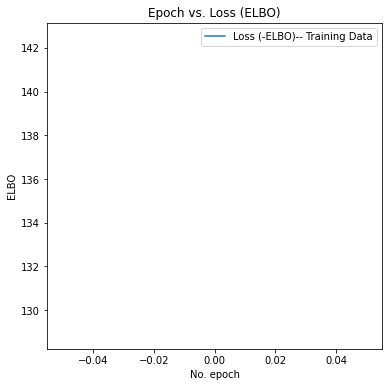

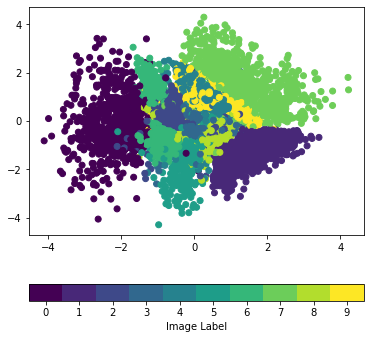

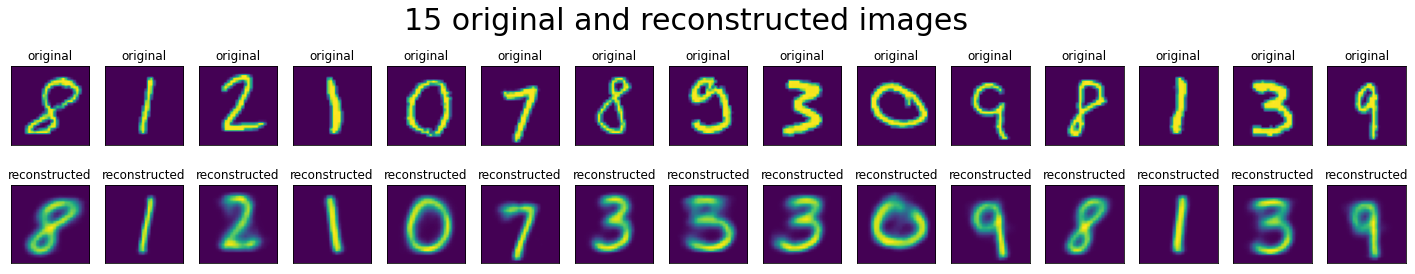

<Figure size 432x288 with 0 Axes>

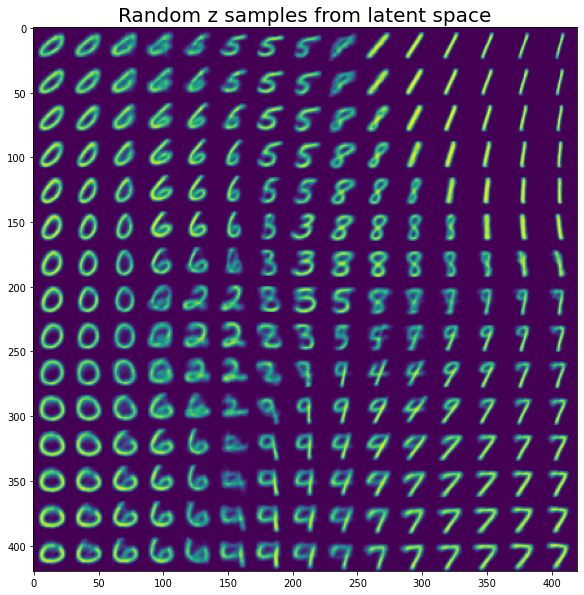

In [28]:
epochs = 1
run_training(1,False) 
plot_latent_space(1)
plot_images(1)
plot_samples(1)
                  

Epoch 1/4
469/469 [==============================] - 2s 5ms/step - loss: 135.4619 - reconstruction_loss: 128.5892 - kl_loss: 7.0098
Epoch 2/4
469/469 [==============================] - 2s 5ms/step - loss: 135.1685 - reconstruction_loss: 128.3780 - kl_loss: 7.0193
Epoch 3/4
469/469 [==============================] - 2s 5ms/step - loss: 135.5083 - reconstruction_loss: 128.4170 - kl_loss: 7.0202
Epoch 4/4
469/469 [==============================] - 2s 5ms/step - loss: 135.5278 - reconstruction_loss: 128.4369 - kl_loss: 7.0286


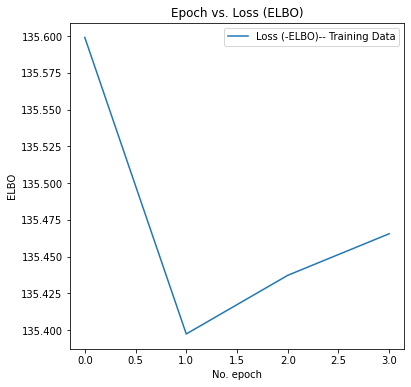

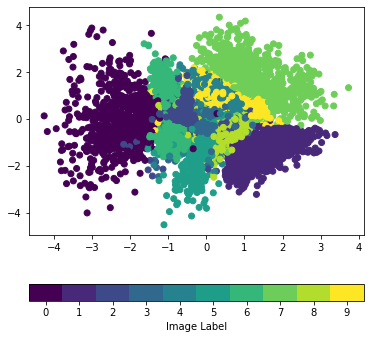

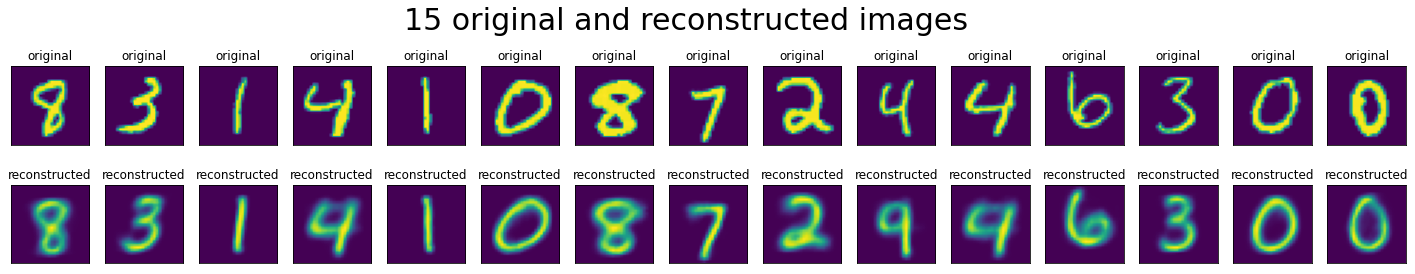

<Figure size 432x288 with 0 Axes>

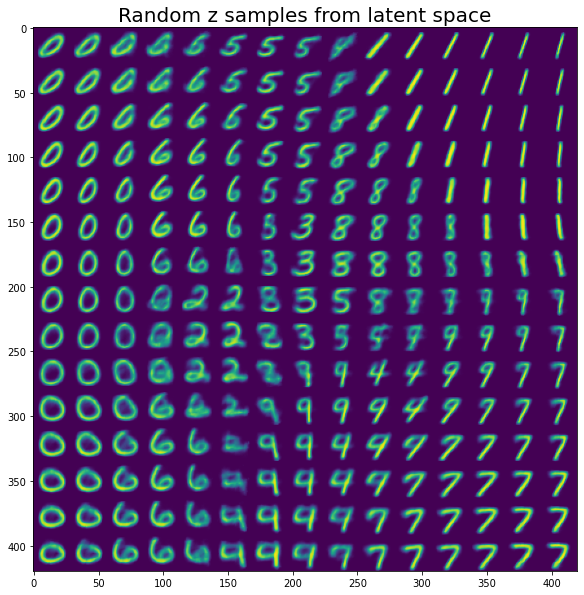

In [29]:

epochs = 4
run_training(epochs,False)  
plot_latent_space(4)
plot_images(4)
plot_samples(4)

Epoch 1/20
469/469 [==============================] - 3s 7ms/step - loss: 135.1656 - reconstruction_loss: 128.2811 - kl_loss: 7.0390
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 134.8511 - reconstruction_loss: 128.1467 - kl_loss: 7.0278
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 135.2276 - reconstruction_loss: 128.0730 - kl_loss: 7.0517
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 135.2352 - reconstruction_loss: 128.1159 - kl_loss: 7.0458
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 135.0407 - reconstruction_loss: 128.1256 - kl_loss: 7.0358
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 135.6511 - reconstruction_loss: 128.2827 - kl_loss: 7.0657
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 134.8713 - reconstruction_loss: 128.1253 - kl_loss: 7.0555
Epoch 8/20
469/469 [==============================] - 3s 7ms/step - l

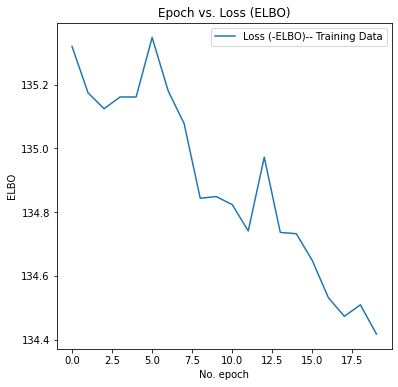

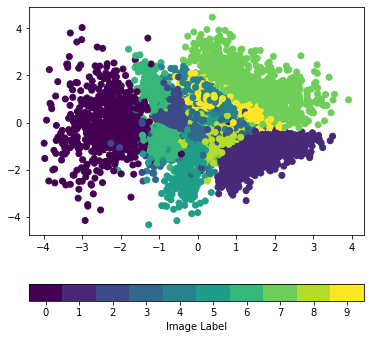

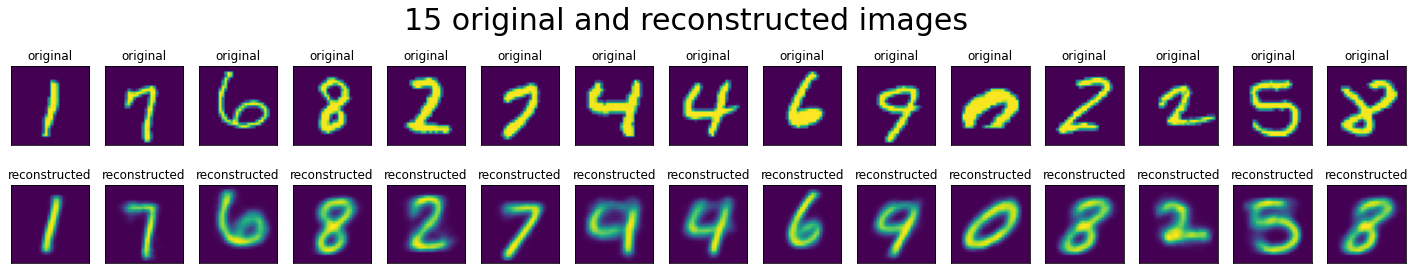

<Figure size 432x288 with 0 Axes>

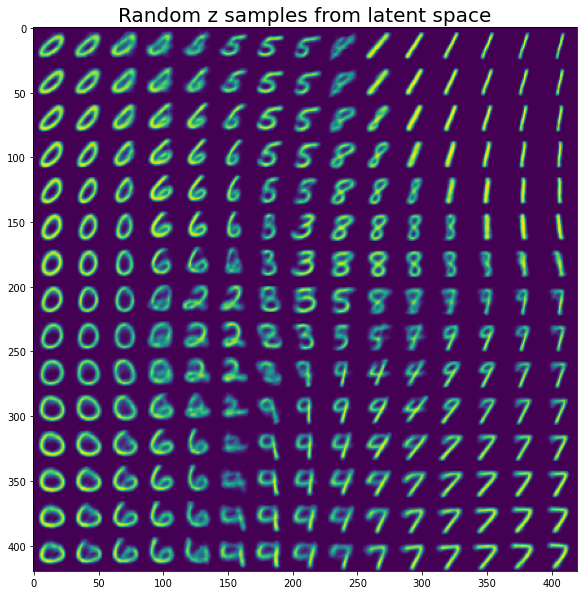

In [30]:

epochs = 20
run_training(epochs,False)  
plot_latent_space(20)
plot_images(20)
plot_samples(20)

In [ ]:
epochs = 150
run_training(epochs,False)  
plot_latent_space(150)
plot_images(150)
plot_samples(150)